# TABLE OF CONTENTS

<a href="#settingup"> Setting Up the Workbook</a></li>
    
<a href="#gathering"> Gathering the Data</a></li>

<a href="#assessing"> Assessing the Data</a></li>

<a href="#storing"> Storing the Data</a></li>

<a href="#visuals"> Visualizations</a></li>

<a href="#insights"> Insights and Documentation</a></li>

## <h2 id="settingup"> Setting Up the Workbook</h2>

Below we will be importing several needed libraries and setting a few options to improve usability.

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
consumer_key = 'jyyqvPjTYwU79YCLvBj0SIbd9'
consumer_secret = 'vTEOLzqaY9mtgpk5j5Ntnhwh75Mg83YXdaqhVU5o22Uyv711XZ'
access_token = '711651407477080065-CsPxGXKPp7ZyDQ6GFxNC57CLibJ2zcn'
access_secret = 'HGZ1Jj3gSbXh4d3MLS6XTKi28hgZm9QpDQwUoNXHuX3LE'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

## <h2 id="gathering"> Gathering the Data </h2>

#### Using tweepy & json to write tweets to text file

In the following cell, initialize the df_archive dataframe by reading in the local file.

After that, we set up a list titled tweet_ids to hold a list of tweet ids for future use.

Lastly we use a for loop to create tweet_json.txt and ping the Twitter api where it returns all tweet data and writes it into the tweet_json.txtfile.

### * Key Information Has Been Omitted

In [3]:
df_archive = pd.read_csv('twitter-archive-enhanced.csv')
tweet_ids = np.array(df_archive['tweet_id'])
errors = []

#loops through tweet_ids, pings Twitter API, stores tweet data in tweet_json.txt
with open ('tweet_json.txt', 'w') as file:
    for id in tweet_ids:
        try:
            tweet = api.get_status(id, tweet_mode = 'extended')
            json.dump(tweet._json, file)
            file.write('\n')
            
               
        except:
            errors.append(id)
print('Complete')    
print(len(errors))

Complete
1484


#### Converting text file into list to be used in creating dataframe

First, we set up an empy list tweet_list to hold the contents of the tweet_json.txt file

In the second half of the cell, we use a for loop to write contents of the file to the list.

In [3]:
#initializing tweet list to store list of dictionaries. Each dictionary is a tweet.
tweet_list = []

#loops through each line of the tweet_json.txt file and uses json.loads to convert tweet in string format to tweet in dictionary format. Dictionaries are appended to tweet_list
from pandas import json_normalize
with open('tweet_json.txt', 'r') as file:
    contents = file.readlines()
    for line in contents:
        js = json.loads(line)
        tweet_list.append(js)          

In [4]:
len(tweet_list)

872

#### Using requests library to download image_predictions.tsv

In the below cell, we use the requests.get() call to ping the url provided and download the file image-predictions.tsv.

Once the file is downloaded, it is written to a file and saved locally.

In [5]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

image_predictions = requests.get(url)

with open('image_predictions.tsv', 'wb') as file:
    file.write(image_predictions.content)

#### Creating 3 Seperate Dataframes 

Now that we have all 3 data sources ready to be used, we initialize 3 dataframes to hold each different source.

In [6]:
#converts list of dictionaries (tweets) into a dataframe (df_counts)
df_counts = pd.DataFrame(tweet_list)

#converts image_predictions.tsv file into dataframe (df_images)
df_images = pd.read_csv('image_predictions.tsv', sep = '\t')

#converts twitter-archive-enhanced.csv into dataframe (df_archive)
df_archive = pd.read_csv('twitter-archive-enhanced.csv')

#### Dropping all unneccessary columns in df_counts with loop

Many unneccessary columns came with the twitter api data, and those are dropped in this cell.

In [7]:
#loops through column names and drops those not included in keeper_columns list

keeper_columns = ['id', 'retweet_count', 'favorite_count']
for column_name, value in df_counts.iteritems():
    if column_name not in keeper_columns:
        df_counts.drop(column_name, axis=1, inplace = True)

## <h2 id="assessing"> Assessing the Data </h2>

### Displaying all Data

Here we will be displaying all 3 dataframes for visual assessment.

In [8]:
df_counts.sample(5)

,id,retweet_count,favorite_count
48,882762694511734784,4063,24600
191,853760880890318849,5092,25918
215,848324959059550208,4119,22688
791,771014301343748096,1530,6444
175,856526610513747968,1644,10771


In [9]:
df_images.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
212,670037189829525505,https://pbs.twimg.com/media/CUxzQ-nWIAAgJUm.jpg,1,pot,0.273767,False,tray,0.092888,False,doormat,0.050728,False
1557,793226087023144960,https://pbs.twimg.com/media/CwIa5CjW8AErZgL.jpg,1,wire-haired_fox_terrier,0.456047,True,Lakeland_terrier,0.273428,True,English_springer,0.083643,True
1329,757596066325864448,https://pbs.twimg.com/media/CoOFmk3WEAAG6ql.jpg,1,doormat,0.845256,False,wallet,0.095718,False,wool,0.026072,False
1775,828372645993398273,https://pbs.twimg.com/media/C374hb0WQAAIbQ-.jpg,1,malamute,0.663047,True,Eskimo_dog,0.207779,True,Tibetan_mastiff,0.040949,True
1296,752173152931807232,https://pbs.twimg.com/media/CnBBfNuWcAAkOgO.jpg,1,Labrador_retriever,0.527659,True,German_shepherd,0.174765,True,Chihuahua,0.045525,True


In [10]:
df_images['p1'].value_counts()[:11]

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
chow                   44
Samoyed                43
toy_poodle             39
Pomeranian             38
cocker_spaniel         30
malamute               30
Name: p1, dtype: int64

In [11]:
df_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
173,858471635011153920,NaN,NaN,2017-04-30 00:02:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She just arrived. Used paworit...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/858471635...,13,10,Sophie,None,None,None,None
686,788070120937619456,NaN,NaN,2016-10-17 17:32:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bo and Ty. Bo eats pape...,7.610045e+17,4.196984e+09,2016-08-04 01:03:17 +0000,https://twitter.com/dog_rates/status/761004547...,11,10,Bo,None,None,None,None
774,776218204058357768,NaN,NaN,2016-09-15 00:36:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Atlas rolled around in some chalk and now he's...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/776218204...,13,10,None,None,floofer,None,None
1749,679047485189439488,NaN,NaN,2015-12-21 21:15:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This dog doesn't know how to stairs. Quite tra...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679047485...,9,10,None,None,None,None,None
1745,679148763231985668,NaN,NaN,2015-12-22 03:57:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I know everyone's excited for Christmas but th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679148763...,8,10,None,None,None,None,None


In [12]:
df_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              872 non-null    int64
 1   retweet_count   872 non-null    int64
 2   favorite_count  872 non-null    int64
dtypes: int64(3)
memory usage: 20.6 KB


In [13]:
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [14]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [15]:
df_counts.describe()

,id,retweet_count,favorite_count
count,8.720000e+02,872.000000,872.000000
mean,8.200722e+17,4319.292431,12914.899083
std,3.684925e+16,4856.793663,13506.750448
min,7.588287e+17,1.000000,0.000000
25%,7.895822e+17,1795.000000,4986.250000
50%,8.184220e+17,2952.000000,9850.500000
75%,8.480372e+17,5053.250000,18167.500000
max,8.924206e+17,51195.000000,123125.000000


In [16]:
df_images.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [17]:
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [18]:
df_counts.shape

(872, 3)

In [19]:
df_images.shape

(2075, 12)

In [20]:
df_archive.shape

(2356, 17)

In [21]:
df_archive['name'].value_counts()[:11]

None       745
a           55
Charlie     12
Cooper      11
Lucy        11
Oliver      11
Tucker      10
Penny       10
Lola        10
Winston      9
Bo           9
Name: name, dtype: int64

In [22]:
df_archive['rating_denominator'].value_counts()[:11]

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
Name: rating_denominator, dtype: int64

In [23]:
df_archive['source'].value_counts()[:4]

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

#### Quality Issues:

- df_archive table: includes retweets which will need to be removed
- df_archive table: The timestamp column is of the object data type, this should be transformed to the datetime datatype.
- df_archive table: The puppo, doggo, flooter, & pupper columns contain many rows valued "none". These should be set to null.
- df_archive table: There are many incorrect/missing values in the name column. These will need to be made null. 
- df_archive table: The source column contains href tags and will need to be cleaned up to include only the actual source i.e. 'Twitter for iPhone'.
- df_archive table: There are several columns not needed for analysis, and should be dropped.
- df_counts table: The "id" column in the df_counts df will need to be changed to match tweet_id from the other 2 dfs.
- df_arhive table: The numerator & denominator columns can be dropped once the columns are combined.



#### Tidiness Issues:
- df_archive table: Rating numerator & denominator should be combined into 1 column
- df_archive table: The dog stage data needs to be combined into 1 column. 
- df_archive & df_counts tables: all data frames should be combined.

## <h2 id="cleaning"> Cleaning the Data </h2>

In [24]:
# creates copies of dataframes/tables that will be cleaned.
df_counts_clean = df_counts.copy()
df_archive_clean = df_archive.copy()
df_images_clean = df_images.copy()

### Missing Data

-There are many incorrect/missing values in the name column. Many begin with lowercase letter. We will make them match the other known missing values which are labeled "None".


#### Define:
Use .loc method to make names beginning with lowercase letter equal to "None"

#### Code

In [25]:
lowers = []

for name in df_archive_clean['name']:
    if name[0].islower():
        lowers.append(name)

for l in lowers:
    df_archive_clean.loc[df_archive_clean['name'] == l, 'name'] = "None"

#### Test

In [26]:
# loop below shows that all values beginning with lower case are gone. They have been changed to "None"

lowers = []
for name in df_archive_clean['name']:
    if name[0].islower():
        lowers.append(name)
print(lowers)
print(df_archive_clean['name'].value_counts()[0])

[]
854


#### Define:
Use df.drop to remove retweets

#### Code:

In [27]:
df_archive_clean.drop(df_archive_clean[df_archive_clean['retweeted_status_id'].notnull()].index, inplace = True)

#### Test

In [28]:
# Below shows that all tweets with retweet status have been removed from the df_archived_clean table. 

df_archive_clean['retweeted_status_id'].value_counts()

Series([], Name: retweeted_status_id, dtype: int64)

#### Define:
 df_archive table: The puppo, doggo, flooter, & pupper columns contain many rows valued "none".
 We are going to make those values NaN. using .loc and np.nan


#### Code:

In [29]:
df_archive_clean.loc[df_archive_clean['doggo'] == 'None', 'doggo'] = np.nan
df_archive_clean.loc[df_archive_clean['floofer'] == 'None', 'floofer'] = np.nan
df_archive_clean.loc[df_archive_clean['pupper'] == 'None', 'pupper'] = np.nan
df_archive_clean.loc[df_archive_clean['puppo'] == 'None', 'puppo'] = np.nan

#### Test:

In [30]:
# shows value counts for all columns and the None values are now NaN.

print(df_archive_clean['pupper'].value_counts())
print(df_archive_clean['floofer'].value_counts())
print(df_archive_clean['pupper'].value_counts())
print(df_archive_clean['puppo'].value_counts())

pupper    234
Name: pupper, dtype: int64
floofer    10
Name: floofer, dtype: int64
pupper    234
Name: pupper, dtype: int64
puppo    25
Name: puppo, dtype: int64


#### Define:
Below we will use regex imported as re to slice the source string data and return only the info we want

#### Code:

In [31]:
import re

def clean_source(source):
    if re.search('>', source):
        pos = re.search('>', source).end()
        return source[pos:-4]

df_archive_clean['source'] = df_archive_clean['source'].apply(clean_source)

#### Test

In [32]:
#Below shows the new values of the source column
df_archive_clean['source'].value_counts()

Twitter for iPhone     2042
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

#### Define

df_archive table: The timestamp column is of the object data type.

We will convert this column using pd.to_datetime

#### Code

In [33]:
#converts timestamp column to datetime
df_archive_clean['timestamp'] = pd.to_datetime(df_archive_clean['timestamp'])

#### Test

In [34]:
# timestamp column is shown as datetime data type below
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2175 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2175 non-null   datetime64[ns, UTC]
 4   source                      2175 non-null   object             
 5   text                        2175 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2117 non-null   object             
 10  rating_numerator            2175 non-null   int64           

#### Define

- df_archive table: we will use .drop to remove all unneeded columns


#### Code

In [35]:
df_archive_clean.drop(columns = ['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','in_reply_to_status_id','in_reply_to_user_id','expanded_urls'], axis = 1, inplace = True)

#### Test

In [36]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   int64              
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   object             
 3   text                2175 non-null   object             
 4   rating_numerator    2175 non-null   int64              
 5   rating_denominator  2175 non-null   int64              
 6   name                2175 non-null   object             
 7   doggo               87 non-null     object             
 8   floofer             10 non-null     object             
 9   pupper              234 non-null    object             
 10  puppo               25 non-null     object             
dtypes: datetime64[ns, UTC](1), int64(3), object(7)
memory usage: 203.9+ KB


#### Define

The dog stages are in seperate columns and should be combined to form 1 column. 

#### Code

In [37]:
df_archive_clean['stage'] = df_archive_clean['doggo'].astype(str) + df_archive_clean['floofer'].astype(str) + df_archive_clean['pupper'].astype(str) + df_archive_clean['puppo'].astype(str)

In [38]:
df_archive_clean['stage'].value_counts()

nannannannan          1831
nannanpuppernan        224
doggonannannan          75
nannannanpuppo          24
doggonanpuppernan       10
nanfloofernannan         9
doggonannanpuppo         1
doggofloofernannan       1
Name: stage, dtype: int64

In [39]:
df_archive_clean.loc[df_archive_clean.stage == 'nannanpuppernan', 'stage'] = 'pupper' 
df_archive_clean.loc[df_archive_clean.stage == 'nannannannan', 'stage'] = np.nan
df_archive_clean.loc[df_archive_clean.stage == 'doggonannannan', 'stage'] = 'doggo'
df_archive_clean.loc[df_archive_clean.stage == 'nannannanpuppo', 'stage'] = 'puppo'
df_archive_clean.loc[df_archive_clean.stage == 'doggonanpuppernan', 'stage'] = 'doggo,puppo'
df_archive_clean.loc[df_archive_clean.stage == 'nanfloofernannan', 'stage'] = 'floofer'
df_archive_clean.loc[df_archive_clean.stage == 'nanfloofernannan', 'stage'] = 'floofer'
df_archive_clean.loc[df_archive_clean.stage == 'doggonannanpuppo', 'stage'] = 'doggo,puppo'
df_archive_clean.loc[df_archive_clean.stage == 'doggofloofernannan', 'stage'] = 'doggo,floofer'

In [40]:
df_archive_clean.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN,NaN,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN,NaN,NaN,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN,NaN,NaN,NaN,NaN
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,13,10,Darla,NaN,NaN,NaN,NaN,NaN
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,12,10,Franklin,NaN,NaN,NaN,NaN,NaN


In [41]:
df_archive_clean.drop(['doggo','floofer','pupper','puppo'], axis = 1, inplace = True)

In [42]:
df_archive_clean['stage'].value_counts()

pupper           224
doggo             75
puppo             24
doggo,puppo       11
floofer            9
doggo,floofer      1
Name: stage, dtype: int64

#### Test

#### Define

The rating numerator & denominator should be combined into 1 column


#### Code

In [43]:
df_archive_clean['doge_rating'] = df_archive_clean['rating_numerator'] / df_archive_clean['rating_denominator']

#### Test

In [44]:
# new column has been successfully added converting numerator and denominator into decimal score
df_archive_clean['doge_rating'].value_counts()

1.200000      504
1.000000      444
1.100000      431
1.300000      307
0.900000      156
0.800000       98
0.700000       53
1.400000       43
0.500000       37
0.600000       32
0.300000       19
0.400000       15
0.200000       11
0.100000        7
42.000000       2
0.000000        2
1.250000        1
0.636364        1
0.818182        1
177.600000      1
2.700000        1
66.600000       1
7.500000        1
3.428571        1
1.700000        1
0.733333        1
inf             1
1.500000        1
18.200000       1
2.600000        1
Name: doge_rating, dtype: int64

#### Define
The numerator and denominator columns can now be dropped because the doge_rating column has been added

this will be done using .drop

#### Code

In [45]:
df_archive_clean.drop(columns=['rating_numerator','rating_denominator'], axis=1, inplace= True)

#### Test

In [46]:
#numerator and denominator are gone, replaced by doge_rating
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   tweet_id     2175 non-null   int64              
 1   timestamp    2175 non-null   datetime64[ns, UTC]
 2   source       2175 non-null   object             
 3   text         2175 non-null   object             
 4   name         2175 non-null   object             
 5   stage        344 non-null    object             
 6   doge_rating  2175 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(4)
memory usage: 135.9+ KB


#### Define
df_counts_clean table: We will use .rename to change the column 'id' to match 'tweet_id'

#### Code:

In [47]:
df_counts_clean.rename(columns={'id':'tweet_id'}, inplace = True)

#### Test

In [48]:
# tweet_id has successfully replaced 'id'
df_counts_clean.head(1)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6945,33578


#### Define

using pd.merge, we will combine all 3 dataframes

#### Code:

In [49]:
df_tweets = df_archive_clean.merge(df_counts_clean, on = 'tweet_id', how = 'left')
df_tweets = df_tweets.merge(df_images_clean, on = 'tweet_id', how = 'left')

#### Test

In [50]:
#programmtic tests below show that the merge was successful
df_tweets['stage'].value_counts()

pupper           224
doggo             75
puppo             24
doggo,puppo       11
floofer            9
doggo,floofer      1
Name: stage, dtype: int64

In [51]:
df_tweets.shape

(2175, 20)

In [52]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        2175 non-null   int64              
 1   timestamp       2175 non-null   datetime64[ns, UTC]
 2   source          2175 non-null   object             
 3   text            2175 non-null   object             
 4   name            2175 non-null   object             
 5   stage           344 non-null    object             
 6   doge_rating     2175 non-null   float64            
 7   retweet_count   725 non-null    float64            
 8   favorite_count  725 non-null    float64            
 9   jpg_url         1994 non-null   object             
 10  img_num         1994 non-null   float64            
 11  p1              1994 non-null   object             
 12  p1_conf         1994 non-null   float64            
 13  p1_dog          1994 non-null   o

## <h2 id="storing"> Storing the Data </h2>

In [53]:
df_tweets.to_csv('twitter_archive_master.csv', index=False)

## <h2 id="visuals"> Visualizing the Data </h2>

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

##### For the below horizontal bar charts, we have calculated the avg favorite count, doge rating, and retweet count for each type of dog. 

##### In the below visualization, we are using the favorites data and timestamp data to create a very simple line plot showing how the number of avg favorites has fluctuated month to month from 2015 - 2017.

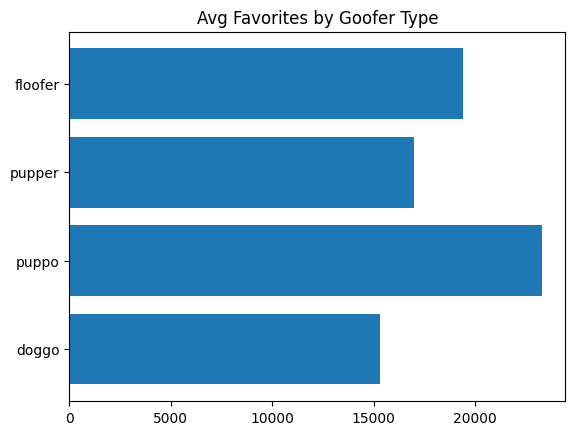

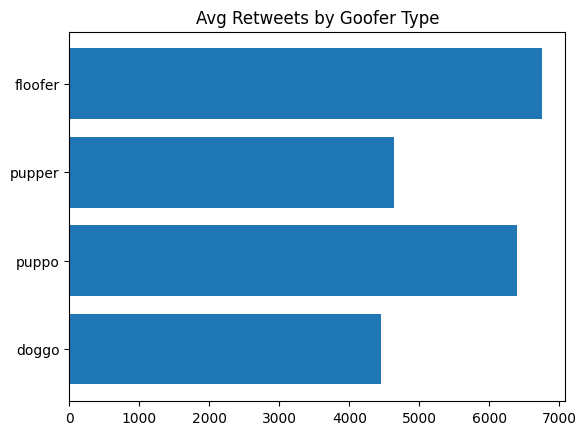

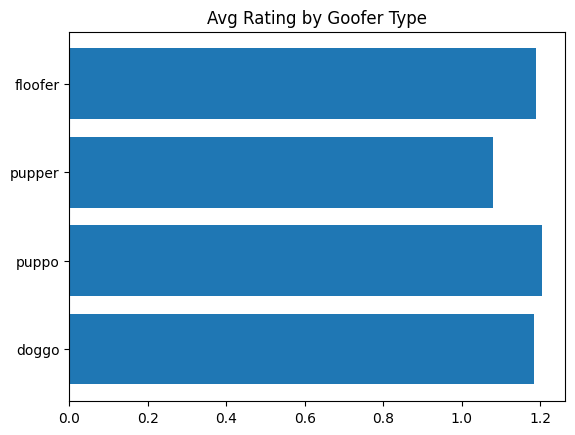

In [55]:
goofer_list = np.array(df_tweets[df_tweets['stage'].notnull()]['stage'].unique())
goofer_list = goofer_list.tolist()
for goofer in goofer_list:
    if goofer == 'doggo,floofer':
        goofer_list.remove(goofer)
        
for goofer in goofer_list:
    if goofer == 'doggo,puppo':
        goofer_list.remove(goofer)

favorite_list = []
retweet_list = []
rating_list = []

for goof in goofer_list:
    dfx = df_tweets[df_tweets['stage'] == goof]
    avg_favs = dfx['favorite_count'].mean()
    favorite_list.append(avg_favs)
    avg_rts = dfx['retweet_count'].mean()
    retweet_list.append(avg_rts)
    avg_rating = dfx['doge_rating'].mean()
    rating_list.append(avg_rating)


plt.barh(goofer_list, favorite_list)
plt.title('Avg Favorites by Goofer Type')
plt.show()

plt.barh(goofer_list, retweet_list)
plt.title('Avg Retweets by Goofer Type')
plt.show()


plt.barh(goofer_list, rating_list)
plt.title('Avg Rating by Goofer Type')
plt.show()


    

Text(0.5, 0, 'Date')

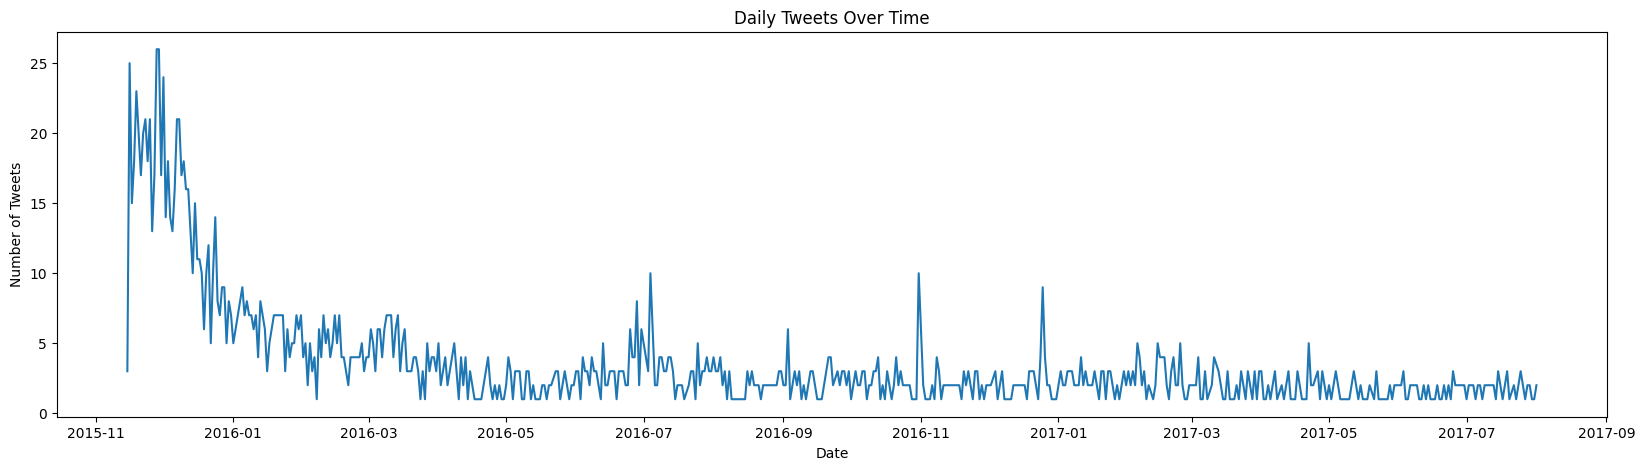

In [68]:
df_tweets['date'] = df_tweets['timestamp'].dt.date

df_days = df_tweets.groupby(by='date', as_index=False)['tweet_id'].count()

plt.plot(df_days['date'], df_days['tweet_id'])
plt.rcParams["figure.figsize"] = (20,5)
plt.title('Daily Tweets Over Time')
plt.ylabel('Number of Tweets')
plt.xlabel('Date')

## <h2 id="insights"> Insights and Documentation </h2>

1. Puppos get the most love in all categories (No Surprise Here)
2. Puppers are the least loved in all categories (Sad Day)
3. From 2015 - 2017, the number of daily tweets decreased steadily.